In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', ''); iskaggle

''

In [2]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()

In [3]:
path = Path('us-patent-phrase-to-phrase-matching')

In [4]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [5]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [6]:
import pandas as pd 

In [7]:
df = pd.read_csv(path/'train.csv'); df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [8]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [9]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df

,id,anchor,target,context,score,input
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,TEXT1: A47; TEXT2: abatement of pollution; ANC...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,TEXT1: A47; TEXT2: forest region; ANC1: abatement
...,...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00,TEXT1: B44; TEXT2: wooden article; ANC1: wood ...
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50,TEXT1: B44; TEXT2: wooden box; ANC1: wood article
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50,TEXT1: B44; TEXT2: wooden handle; ANC1: wood a...
36471,756ec035e694722b,wood article,wooden material,B44,0.75,TEXT1: B44; TEXT2: wooden material; ANC1: wood...


## Tokenization

In [10]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

In [11]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [12]:
ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'score': 0.5,
 'input': 'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement'}

In [13]:
model_nm = 'microsoft/deberta-v3-small'

In [14]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
tokz

PreTrainedTokenizerFast(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [16]:
tokz("Greetings, earthlings. I'm here to talk to y'all about other universes!")

{'input_ids': [1, 29641, 261, 2574, 20289, 260, 273, 280, 358, 422, 264, 1072, 264, 2982, 280, 3068, 314, 340, 54300, 300, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
# the 'input' field comes from our df 
tok_ds = ds.map(lambda x: tokz(x['input']), batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [18]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [19]:
tok_ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'score': 0.5,
 'input': 'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 'input_ids': [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokz.tokenize('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement')

['▁TEXT',
 '1',
 ':',
 '▁A',
 '47',
 ';',
 '▁TEXT',
 '2',
 ':',
 '▁abatement',
 '▁of',
 '▁pollution',
 ';',
 '▁ANC',
 '1',
 ':',
 '▁abatement']

Prove to ourselves that the numbers are simply a dictionary lookup from the vocab 

In [21]:
[tokz.vocab[x] for x in tokz.tokenize('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement')]

[54453,
 435,
 294,
 336,
 5753,
 346,
 54453,
 445,
 294,
 47284,
 265,
 6435,
 346,
 23702,
 435,
 294,
 47284]

Make huggingface happy by naming score column (i.e. the ML target) to 'labels'

In [22]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [23]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

## Test and validation sets 

In [24]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


### Foray into overfitting

In [25]:
def f(x): return -3*x**2 + 2*x + 20

In [26]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

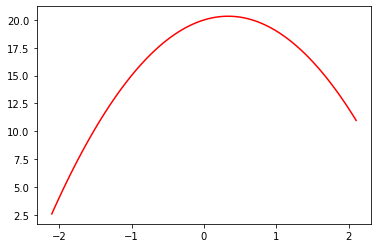

In [27]:
plot_function(f)

In [28]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [29]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

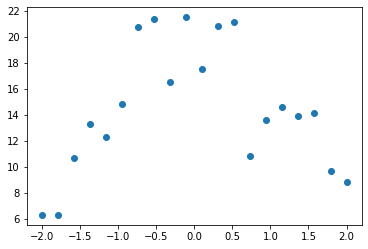

In [30]:
import numpy as np 
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

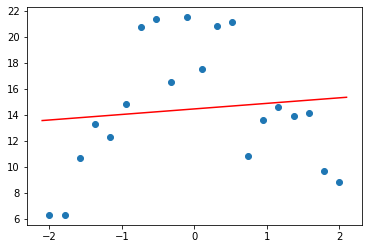

In [32]:
plot_poly(1)

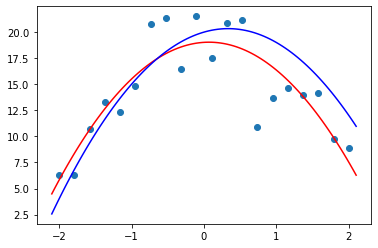

In [33]:
plot_poly(2)
plot_function(f, color='b')

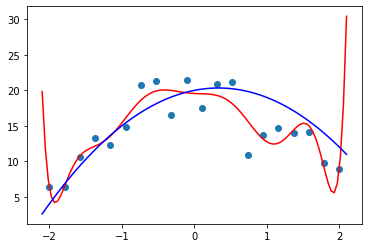

In [34]:
plot_poly(10)
plot_function(f, color='b')

Dangers of cross-validation (i.e. when you randomly split your data into A, B and C and then train on different subsets e.g. A and C and evaluate on B): 

This is only going to be useful if random sampling is creating a good validation set! This is not necessarily the case: e.g. classification problems on pictures of people should be evaluated on unseen people - and you don't get the from random sampling. 

## Metrics and Correlation

In [35]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [36]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [37]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [38]:
def corr(x,y): return np.corrcoef(x,y)[0][1]
corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906005

In [39]:
def show_corr(df, a, b):
    x, y = df[a], df[b]
    r = corr(x, y)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.title(f'r: {r:.2f}')


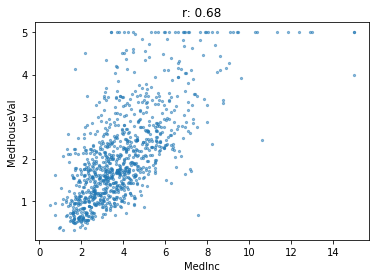

In [40]:
show_corr(housing, 'MedInc', 'MedHouseVal')

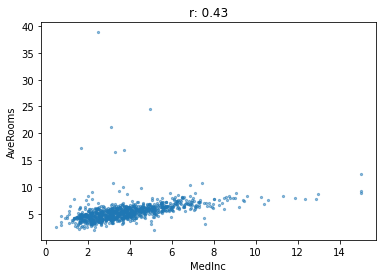

In [41]:
show_corr(housing, 'MedInc', 'AveRooms')

We see some heavy outliers, and that removing them increases the correlation score drastically 

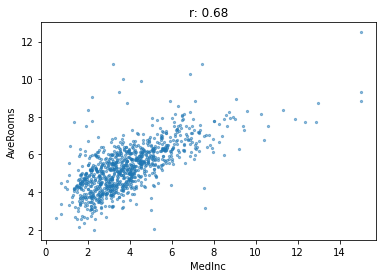

In [42]:
subset = housing[housing.AveRooms < 15] ; subset
show_corr(subset, 'MedInc', 'AveRooms')

### Build a validation set

In [43]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [44]:
def tok_func(x): return tokz(x["input"])

In [45]:
eval_df.shape

(36, 4)

In [46]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
eval_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})

## Train a model 

In [48]:
from transformers import TrainingArguments, Trainer 

In [49]:
bs = 128 
epochs = 4

To find a good learning rate without an optimizer, just pick a low learning rate and verify that it works ok, and then try to keep doubling it until things fall apart 

In [50]:
lr = 8e-5

In [51]:
args=TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type = 'cosine', fp16=True, evaluation_strategy='epoch', per_device_train_batch_size=bs*2, num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [52]:
from transformers import AutoModelForSequenceClassification

In [63]:
AutoModelForSequenceClassification??

Init signature: AutoModelForSequenceClassification(*args, **kwargs)
Docstring:     
This is a generic model class that will be instantiated as one of the model classes of the library (with a sequence classification head) when created
with the [`~AutoModelForSequenceClassification.from_pretrained`] class method or the [`~AutoModelForSequenceClassification.from_config`] class
method.

This class cannot be instantiated directly using `__init__()` (throws an error).
Source:        
class AutoModelForSequenceClassification(_BaseAutoModelClass):
    _model_mapping = MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
File:           /opt/conda/lib/python3.7/site-packages/transformers/models/auto/modeling_auto.py
Type:           type
Subclasses:     


In [53]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
def corr_d(eval_predictions): return {'pearson': corr(*eval_predictions)}
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [54]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, id, context, target. If anchor, input, id, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 428
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` met

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.031112,0.786218
2,No log,0.022114,0.822538
3,No log,0.022639,0.826175
4,No log,0.022658,0.830051


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, id, context, target. If anchor, input, id, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, id, context, target. If anchor, input, id, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, id, context, target. If anchor, input,

TrainOutput(global_step=428, training_loss=0.02713708565613934, metrics={'train_runtime': 231.4641, 'train_samples_per_second': 472.713, 'train_steps_per_second': 1.849, 'total_flos': 747252572998440.0, 'train_loss': 0.02713708565613934, 'epoch': 4.0})

In [55]:
# remember the eval_ds is the test set from kaggle without any labels 
eval_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})

In [56]:
prediction = trainer.predict(eval_ds)

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, input, id, context, target. If anchor, input, id, context, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 8


In [57]:
preds = prediction.predictions; preds[:10]

array([[0.57],
       [0.7 ],
       [0.47],
       [0.38],
       [0.  ],
       [0.54],
       [0.48],
       [0.06],
       [0.27],
       [1.08]], dtype=float16)

In [58]:
preds = np.clip(preds, 0, 1); preds[:10]

array([[0.57],
       [0.7 ],
       [0.47],
       [0.38],
       [0.  ],
       [0.54],
       [0.48],
       [0.06],
       [0.27],
       [1.  ]], dtype=float16)

In [59]:
preds.reshape(preds.shape[0])

array([0.57, 0.7 , 0.47, 0.38, 0.  , 0.54, 0.48, 0.06, 0.27, 1.  , 0.25,
       0.26, 0.71, 0.87, 0.75, 0.44, 0.31, 0.  , 0.51, 0.39, 0.4 , 0.2 ,
       0.  , 0.23, 0.61, 0.  , 0.  , 0.  , 0.  , 0.61, 0.37, 0.02, 0.7 ,
       0.52, 0.43, 0.22], dtype=float16)

In [60]:
import pandas as pd 

submission = pd.DataFrame({
    'id': eval_ds['id'],
    'score': preds.reshape(preds.shape[0]),
})
submission.head()

,id,score
0,4112d61851461f60,0.570312
1,09e418c93a776564,0.701660
2,36baf228038e314b,0.468018
3,1f37ead645e7f0c8,0.380371
4,71a5b6ad068d531f,0.003387


In [61]:
submission.to_csv('submission.csv')

In [62]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

ArrowNotImplementedError: Not implemented type for Arrow list to pandas: halffloat